In [44]:
import glob
from string import punctuation

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import Input, Embedding, Dropout, LSTM, Conv2D, Dense, Activation, Reshape, Flatten
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
PATH_TO_DATA = '../data/all_data/'

## Understanding and formating the data

In [4]:
guis_code = glob.glob(PATH_TO_DATA+'*.gui')
guis_sketch = glob.glob(PATH_TO_DATA+'*.png')

assert len(guis_code) == len(guis_sketch)

In [5]:
demo_sketch = '00150311-A7AE-4804-8B7D-9273687B4FC0'

### Init Sketch to DSL Code map

In [6]:
def get_sketch_code_pair(path_to_code):
    sketch = path_to_code.split('/')[3].split('.')[0]    
    with open(path_to_code, 'r') as f:
        code = f.read()
    
    return (sketch, code)
    
def init_sketch2code_map(paths):
    sketch2code = dict()
    
    for path in paths:
        sketch, code = get_sketch_code_pair(path)
        sketch2code[sketch] = code
        
    return sketch2code


sketch2code = init_sketch2code_map(guis_code)

In [7]:
print(sketch2code[demo_sketch])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



### Load the Sketch

In [24]:
def load_sketch(sketch, target_size=(299, 299), preprocess=True) :
    img = image.load_img(PATH_TO_DATA+sketch+'.png', target_size=target_size)
    x = image.img_to_array(img)
    
    if preprocess:
        x = preprocess_input(x)

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


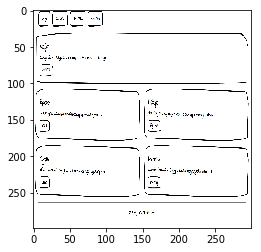

In [25]:
plt.imshow(load_sketch(demo_sketch));

***

## Create a Vocabulary

In [26]:
with open('../vocabulary.txt', 'r') as f:
    vocabulary = f.read().split()

vocabulary.insert(0, '0')

In [27]:
len(vocabulary)

18

### Word2Idx, Idx2Word maps

In [28]:
word2idx = {val: key for key, val in enumerate(vocabulary)}
idx2word = {key: val for key, val in enumerate(vocabulary)}

In [29]:
word2idx

{',': 1,
 '0': 0,
 '<END>': 16,
 '<START>': 13,
 'btn-active': 15,
 'btn-green': 10,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-red': 11,
 'double': 12,
 'header': 14,
 'quadruple': 6,
 'row': 7,
 'single': 17,
 'small-title': 4,
 'text': 5,
 '{': 2,
 '}': 3}

In [30]:
idx2word

{0: '0',
 1: ',',
 2: '{',
 3: '}',
 4: 'small-title',
 5: 'text',
 6: 'quadruple',
 7: 'row',
 8: 'btn-inactive',
 9: 'btn-orange',
 10: 'btn-green',
 11: 'btn-red',
 12: 'double',
 13: '<START>',
 14: 'header',
 15: 'btn-active',
 16: '<END>',
 17: 'single'}

***

## Max DSL Code Length

In [31]:
def tokenize_dsl_code(code):
    tokens = code.split()
    final_tokens = []
    
    for token in tokens:
        if ',' in token:
            final_tokens.append(token.split(',')[0])
            final_tokens.append(',')
        else:
            final_tokens.append(token)
            
    return final_tokens

In [32]:
print('Total number of DSL Codes: {}'.format(len(sketch2code.values())))

Total number of DSL Codes: 1700


In [33]:
longets_code = max(sketch2code.values(), key=lambda x: len(tokenize_dsl_code(x)))

print('Longes code:')
print('='*30)
print()
print(longets_code)

Longes code:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}



In [34]:
max_code_length = len(tokenize_dsl_code(longets_code)) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 117


***

## Train/Dev/Test split

In [35]:
len(sketch2code)

1700

In [36]:
items = list(sketch2code.items())
total_num = len(items)

split = (.9, .05, .05)
borders = (
    int(total_num * split[0]),
    int(total_num * split[0]) + int(total_num * split[1]),
    int(total_num * split[0]) + int(total_num * split[1]) + int(total_num * split[2]),
)

train_sketch_code = dict(items[0:borders[0]])
dev_sketch_code = dict(items[borders[0]:borders[1]])
test_sketch_code = dict(items[borders[1]:borders[2]])

In [37]:
assert len(train_sketch_code) + len(dev_sketch_code) + len(test_sketch_code) == len(sketch2code)

In [38]:
print('Train Set size: {}'.format(len(train_sketch_code)))
print('Dev Set size: {}'.format(len(dev_sketch_code)))
print('Test Set size: {}'.format(len(test_sketch_code)))


Train Set size: 1530
Dev Set size: 85
Test Set size: 85


***

## Data Generator

In [39]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(sketch_code_set, word2idx, max_length, batch_size):
    X_img = np.zeros((batch_size, 299, 299, 3))
    X_seq = []
    Y_seq = []
    n = 0
    
    # loop for ever over images
    while True:
        for sketch, code in sketch_code_set.items():
            # load sketch
            sketch_img = load_sketch(sketch, preprocess=True)
            X_img[n] = sketch_img

            # encode the sequence
            y_seq = [word2idx[word] for word in tokenize_dsl_code(code)] + [word2idx['<END>']]
            x_seq = [word2idx['<START>']] + y_seq[:-1]

            Y_seq.append(y_seq)
            X_seq.append(x_seq)
            
            n+=1
            # yield the batch data
            if n == batch_size:
                X_seq = pad_sequences(X_seq, maxlen=max_length, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=max_length, padding='post')

                # One-hot
                Y_seq = [[to_categorical(idx, len(vocabulary)) for idx in sent] for sent in Y_seq]

                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((batch_size, 299, 299, 3))
                X_seq = []
                Y_seq = []
                n = 0


***

# Sketch Encoder (ConvNet)

In [40]:
HIDDEN_STATE_DIM = 256

In [47]:
img_in = Input((299, 299, 3), name='image_input')

x = Conv2D(16, (3,3), activation='relu', padding='valid', name='conv_16')(img_in)
x = Conv2D(16, (3,3), activation='relu', padding='same', strides=2, name='conv_16_2')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same',  name='conv_32')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', strides=2, name='conv_32_2')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_64')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='conv_64_2')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv_128')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='dense_1')(x)
x = Dropout(0.3, name='dropout_1')(x)
x = Dense(1024, activation='relu', name='dense_2')(x)
x = Dropout(0.3, name='dropout_2')(x)
x = Dense(HIDDEN_STATE_DIM, activation='relu', name='dense_encoder')(x)
    
sketch_encoder = Model(img_in, x, name='sketch_encoder')

In [49]:
# plot_model(sketch_encoder, to_file='sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
conv_16 (Conv2D)             (None, 297, 297, 16)      448       
_________________________________________________________________
conv_16_2 (Conv2D)           (None, 149, 149, 16)      2320      
_________________________________________________________________
conv_32 (Conv2D)             (None, 149, 149, 32)      4640      
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv_64 (Conv2D)             (None, 75, 75, 64)        18496     
_________________________________________________________________
conv_64_2 (Conv2D)           (None, 38, 38, 64)        36928     
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

In [50]:
# Sequence Input
seq_in = Input((max_code_length,), name='sequence_input')
h_state_input = Input((HIDDEN_STATE_DIM,), name='h_state_input')
c_state_input = Input((HIDDEN_STATE_DIM,), name='c_state_input')


# Embeddings
embeddings = Embedding(
    len(vocabulary),
    50,
    input_length=max_code_length,
    mask_zero=True,
    name='embeddings'
)
x = embeddings(seq_in)
    
# Dropout
embeddings_dropout = Dropout(0.5, name='embeddings_dropout')
x = embeddings_dropout(x)

# Sequence Decoder
lstm_decoder = LSTM(HIDDEN_STATE_DIM, return_sequences=True, return_state=True, name='lstm_decoder')
x, _, _ = lstm_decoder(x, initial_state=[h_state_input, c_state_input])

# Dense -> Softmax
dense_decoder = Dense(len(vocabulary), name='dense_decoder')
x = dense_decoder(x)
softmax_decoder = Activation('softmax', name='softmax_decoder')
x = softmax_decoder(x)
    
sequence_decoder = Model(inputs=[seq_in, h_state_input, c_state_input], outputs=x, name='sequence_decoder')


In [52]:
# plot_model(sequence_decoder, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 117, 50)      900         sequence_input[0][0]             
__________________________________________________________________________________________________
embeddings_dropout (Dropout)    (None, 117, 50)      0           embeddings[0][0]                 
__________________________________________________________________________________________________
h_state_input (InputLayer)      (None, 256)          0                                            
__________________________________________________________________________________________________
c_state_in

***

# Model

![NIC_model](../img/Model.png)

In [53]:
encoder_vector = sketch_encoder(img_in)
seq_out = sequence_decoder([seq_in, encoder_vector, encoder_vector])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='model')


### Visualize the model

In [54]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 256)          190726928   image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 117, 18)      319894      sequence_input[0][0]             
                                                                 sketch_encoder[1][0]             
          

***

# Inference

![LSTM_sampling](../img/Sampling.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


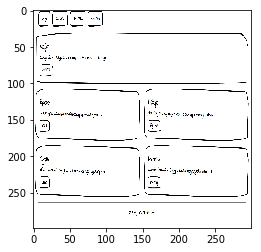

In [55]:
plt.imshow(load_sketch(demo_sketch));

In [56]:
print(sketch2code[demo_sketch])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



In [59]:
def init_inference_decoder():
    embedded = embeddings(seq_in)
    embedded = embeddings_dropout(embedded)

    output_tokens, h_state, c_state = lstm_decoder(embedded, initial_state=[h_state_input, c_state_input])
    output_tokens = dense_decoder(output_tokens)
    output_tokens = softmax_decoder(output_tokens)

    inference_decoder = Model([seq_in, h_state_input, c_state_input], [output_tokens, h_state, c_state])
    
    return inference_decoder

inference_decoder = init_inference_decoder()


def inference(sketch):
    encoder_vector = sketch_encoder.predict(np.array([sketch]))[0]
    states_values = [np.array([encoder_vector]), np.array([encoder_vector])]

    target_seq = np.zeros((1, max_code_length))
    target_seq[0, 0] = word2idx['<START>']

    stop_condition = False
    decoded_seq = ''

    while not stop_condition:
        output_tokens, h_state, c_state = inference_decoder.predict([target_seq]+states_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2word[sampled_token_index]
        decoded_seq += sampled_word + ' '

        # Exit condition
        if (sampled_word == '<END>' or 
            len(tokenize_dsl_code(decoded_seq)) >= max_code_length):
            stop_condition = True
        
        target_seq = np.zeros((1, max_code_length))
        target_seq[0, 0] = sampled_token_index
        
        states_values = [h_state, c_state]

    return decoded_seq[:-1]

In [60]:
# 'subdivsion magnificant affectionately '

inference(load_sketch(demo_sketch))

'<END>'

***

## Run Train

### Callbacks

In [61]:
filepath="weights/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    print(inference(load_sketch(demo_sketch)))

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [62]:
model.compile(Adam(0.0001), loss='categorical_crossentropy')

In [ ]:
batch_size = 32
steps = len(train_sketch_code) // batch_size

model.fit_generator(
    data_generator(train_sketch_code, word2idx, max_code_length, batch_size),
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
47/47 [==============================] - 94s 2s/step - loss: 2.5970

Epoch 00001: saving model to weights/weights-01.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder was passed non-serializable keyword arguments: {'mask': [<tf.Tensor 'sequence_decoder/embeddings/NotEqual:0' shape=(?, 117) dtype=bool>, None, None], 'initial_state': [<tf.Tensor 'h_state_input:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'c_state_input:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


header btn-inactive btn-inactive btn-inactive btn-inactive btn-inactive , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
Epoch 2/100
10/47 [=====>........................] - ETA: 52s - loss: 2.1440

In [66]:
dsl_file = inference(load_sketch(demo_sketch))

In [67]:
dsl_file = dsl_file.replace('{', '{8').replace('}', '8}8')
dsl_file = dsl_file.replace(' ', '')
dsl_file = dsl_file.split('8')
dsl_file = list(filter(None, dsl_file))

In [68]:
dsl_file

['header{',
 'btn-inactive,btn-inactive,btn-inactive,btn-inactive',
 '}',
 'row{',
 'single{',
 'small-title,text,btn-orange',
 '}']